In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing

In [31]:
df = pd.read_csv('/Users/co/Downloads/train.csv')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [39]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')

In [43]:
monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='ME'))['Sales'].sum()
monthly_sales.head()

Order Date
2015-01-31    14205.707
2015-02-28     4519.892
2015-03-31    55205.797
2015-04-30    27906.855
2015-05-31    23644.303
Freq: ME, Name: Sales, dtype: float64

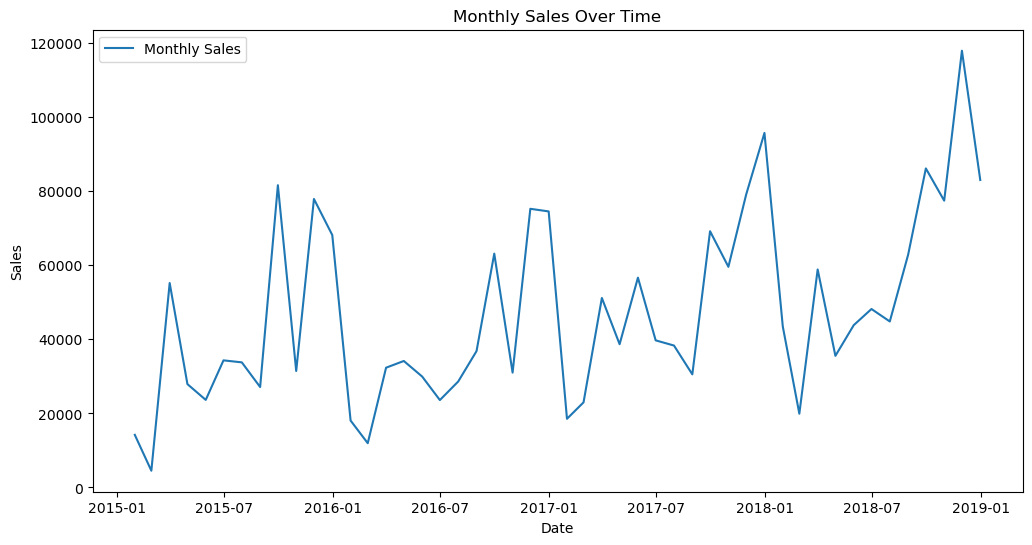

In [47]:
plt.figure(figsize=(12,6))
plt.plot(monthly_sales, label='Monthly Sales')
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

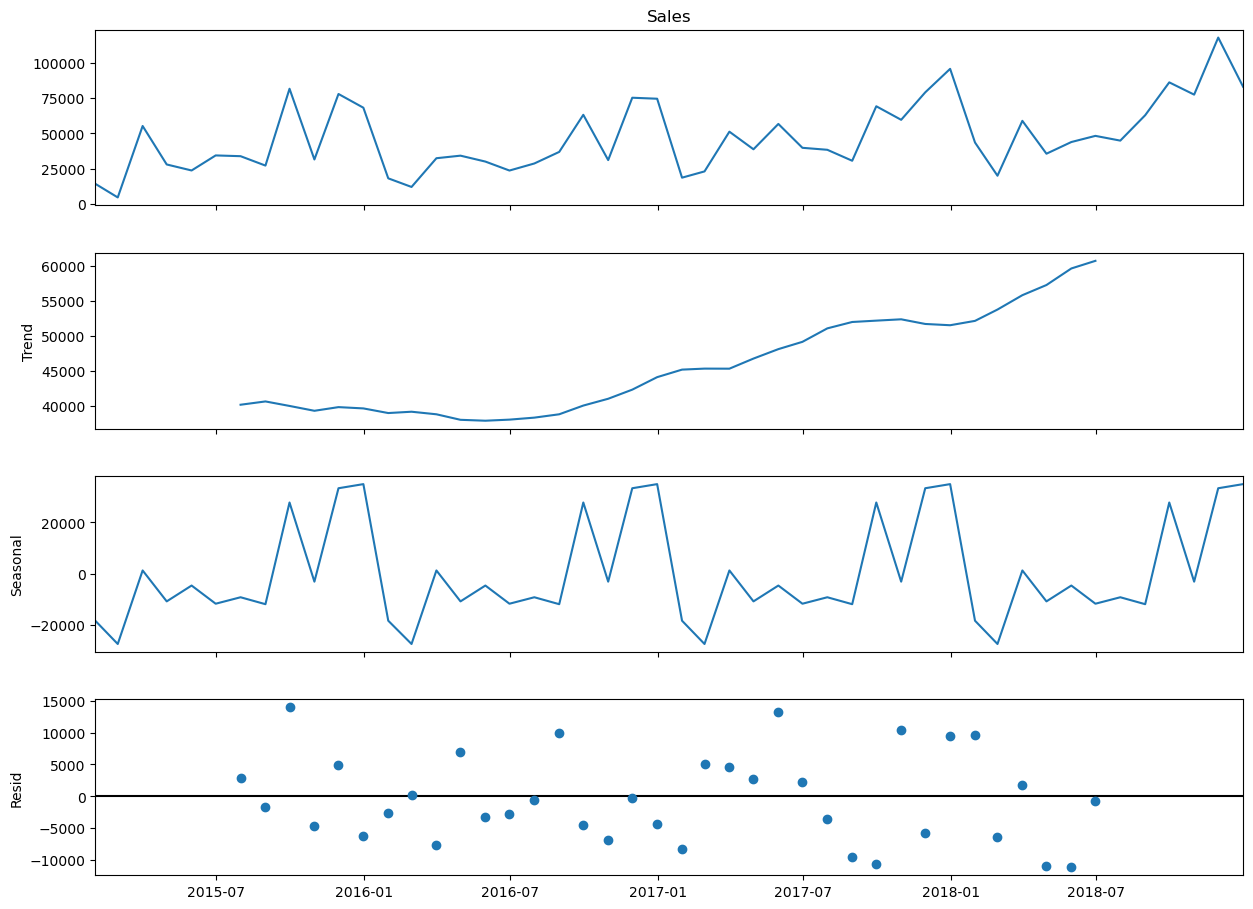

In [49]:
decomposition = seasonal_decompose(monthly_sales, model='additive')
fig = decomposition.plot()
fig.set_size_inches(14,10)
plt.show()

In [51]:
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('Augmented Dickey-Fuller Test Results:')
    print('ADF Statistic:', result[0])
    print('p-value', result[0])
    print('Critical values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    return result[1]<0.05

is_stationary = check_stationarity(monthly_sales)
print(f"\nTime serires is {'stationary' if is_stationary else 'non-stationary'}")

Augmented Dickey-Fuller Test Results:
ADF Statistic: -4.416136761430769
p-value -4.416136761430769
Critical values:
	1%: -3.5778480370438146
	5%: -2.925338105429433
	10%: -2.6007735310095064

Time serires is stationary


In [55]:
auto_model = auto_arima(monthly_sales,
                       start_p=0, start_q=0,
                       max_p=5, max_q=5,
                       m=12,
                       seasonal=True,
                       d=None,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1085.632, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1096.560, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1076.500, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1077.487, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1094.708, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1089.579, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1078.250, Time=0.10 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1078.452, Time=0.03 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1080.901, Time=0.02 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1079.864, Time=0.12 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1084.035, Time=0.19 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=1073.635, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=1087.151, Time=0.01 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=1075.267, Time=0.24 sec
 ARIMA(2,1,0)(1,0,1

In [100]:
model = ARIMA(monthly_sales,
             order=auto_model.order,
             seasonal_order=auto_model.seasonal_order)
results = model.fit()

In [102]:
forecast_periods = 12
forecast = results.get_forecast(steps=forecast_periods)
mean_forecast = forecast.predicted_mean

In [ ]:
forecast_periods = 12
forecast = results.get_forecast(steps=forecast_periods)
mean_forecast = forecast.predicted_mean

In [104]:
conf_int_95 = forecast.conf_int(alpha=0.05)
conf_int_80 = forecast.conf_int(alpha=0.20)
conf_int_70 = forecast.conf_int(alpha=0.30)

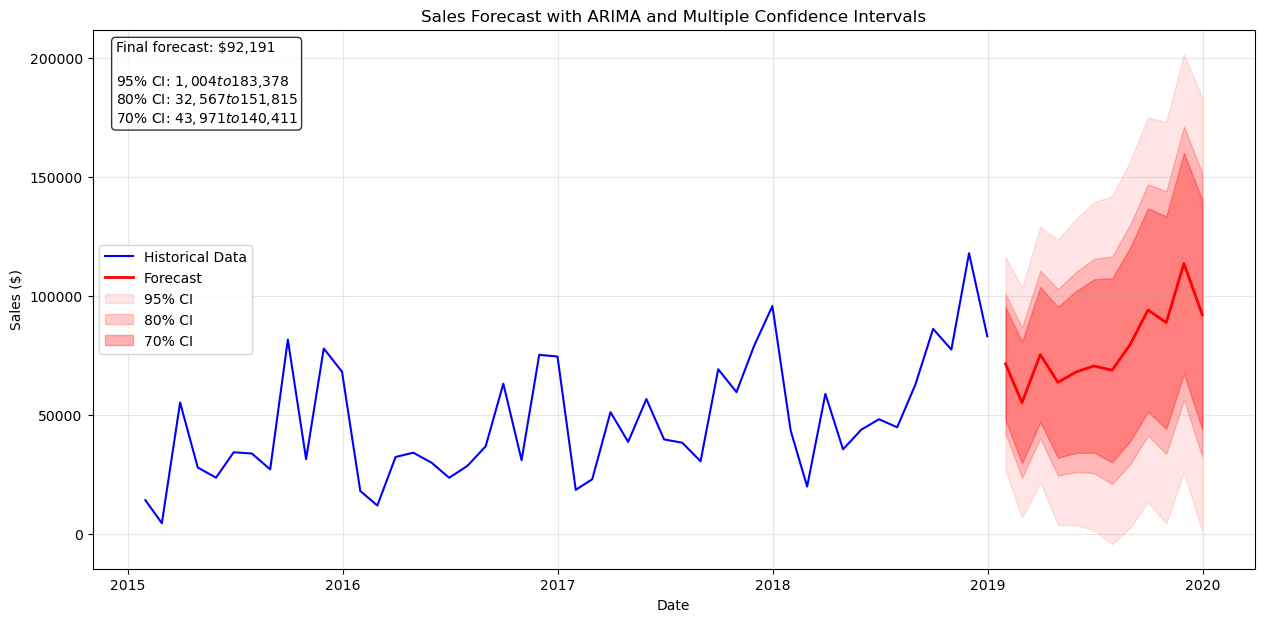

In [120]:
plt.figure(figsize=(15,7))

# Plot historical data and forecast
plt.plot(monthly_sales, label='Historical Data', color='blue')
plt.plot(mean_forecast, label='Forecast', color='red', linewidth=2)

# Plot confidence intervals
plt.fill_between(mean_forecast.index,
                conf_int_95.iloc[:,0],
                conf_int_95.iloc[:,1],
                color='red', alpha=0.1,
                label='95% CI')

plt.fill_between(mean_forecast.index,
                conf_int_80.iloc[:,0],
                conf_int_80.iloc[:,1],
                color='red', alpha=0.2,
                label='80% CI')

plt.fill_between(mean_forecast.index,
                conf_int_70.iloc[:,0],
                conf_int_70.iloc[:,1],
                color='red', alpha=0.3,
                label='70% CI')

plt.title('Sales Forecast with ARIMA and Multiple Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# Get final values
last_forecast = mean_forecast.iloc[-1]
ranges_95_lower = conf_int_95.iloc[-1,0]
ranges_95_upper = conf_int_95.iloc[-1,1]
ranges_80_lower = conf_int_80.iloc[-1,0]
ranges_80_upper = conf_int_80.iloc[-1,1]
ranges_70_lower = conf_int_70.iloc[-1,0]
ranges_70_upper = conf_int_70.iloc[-1,1]

# Create info text
info_text = f'Final forecast: ${last_forecast:,.0f}\n\n'\
            f'95% CI: ${ranges_95_lower:,.0f} to ${ranges_95_upper:,.0f}\n'\
            f'80% CI: ${ranges_80_lower:,.0f} to ${ranges_80_upper:,.0f}\n'\
            f'70% CI: ${ranges_70_lower:,.0f} to ${ranges_70_upper:,.0f}'

plt.text(0.02, 0.98, info_text,
        transform=plt.gca().transAxes,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

In [140]:
# Calculate and display metrics
print("\nModel Performance Metrics:")
mse = mean_squared_error(monthly_sales, results.fittedvalues)
rmse = np.sqrt(mse)
mae = mean_absolute_error(monthly_sales, results.fittedvalues)

print(f"Mean Squared Error (MSE): {mse:2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:2f}")
print(f"Mean Absolute Error (MAE): {mae:2f}")

# Print forecast information
print("\nForecast Ranges for Final Period:")
print(f"Point Forecast: ${last_forecast:,.2f}")
print("\nConfidence Intervals:")
print(f"95% CI: ${ranges_95_lower:,.2f} to ${ranges_95_upper:,.2f}")
print(f"95% CI: ${ranges_80_lower:,.2f} to ${ranges_80_upper:,.2f}")
print(f"95% CI: ${ranges_70_lower:,.2f} to ${ranges_70_upper:,.2f}")

# Calculate and print interval widths
# print(u"\u00B1") = ±
print("\nInterval Widths as Percentage of Forecast:")
print(f"95% CI: ±{((ranges_95_upper - ranges_95_lower)/2/last_forecast*100):,.1f}%")
print(f"80% CI: ±{((ranges_80_upper - ranges_80_lower)/2/last_forecast*100):,.1f}%")
print(f"70% CI: ±{((ranges_70_upper - ranges_70_lower)/2/last_forecast*100):,.1f}%")

# Create forecast dataframe
forecast_df = pd.DataFrame({
    'Forecast': mean_forecast,
    '95% Lower': conf_int_95.iloc[:,0],
    '95% Upper': conf_int_95.iloc[:,1],
    '80% Lower': conf_int_80.iloc[:,0],
    '80% Upper': conf_int_80.iloc[:,1],
    '70% Lower': conf_int_70.iloc[:,0],
    '70% Upper': conf_int_70.iloc[:,1],
})

print("\nDetailed Forecast with Confidence Intervals:")
print(forecast_df)


Model Performance Metrics:
Mean Squared Error (MSE): 372198461.460960
Root Mean Squared Error (RMSE): 19292.445710
Mean Absolute Error (MAE): 14432.381137

Forecast Ranges for Final Period:
Point Forecast: $92,191.07

Confidence Intervals:
95% CI: $1,003.72 to $183,378.42
95% CI: $32,566.87 to $151,815.28
95% CI: $43,970.99 to $140,411.15

Interval Widths as Percentage of Forecast:
95% CI: ±98.9%
80% CI: ±64.7%
70% CI: ±52.3%

Detailed Forecast with Confidence Intervals:
                 Forecast     95% Lower      95% Upper     80% Lower  \
2019-01-31   71457.294765  26519.448480  116395.141051  42074.016443   
2019-02-28   55170.675764   6856.399116  103484.952413  23579.668294   
2019-03-31   75354.273343  21594.176506  129114.370181  40202.435447   
2019-04-30   63712.967973   3787.033089  123638.902857  24529.505281   
2019-05-31   68065.122590   3753.333525  132376.911656  26013.903991   
2019-06-30   70562.386168   1722.863618  139401.908719  25550.641773   
2019-07-31   68781.

In [148]:
models = []
specifications = [
    {
        'name': 'Fixed Parameters',
        'model': ExponentialSmoothing(
            monthly_sales,
            seasonal_periods=12,
            trend='add',
            seasonal='add',
            damped_trend=True
        ).fit(
            smoothing_level=0.2,
            smoothing_trend=0.1,
            smoothing_seasonal=0.1,
            damping_trend=0.98,
            optimized=False
        )
    },
    {
        'name': 'Multiplication Seasonal',
        'model': ExponentialSmoothing(
            monthly_sales,
            seasonal_periods=12,
            trend='add',
            seasonal='mul',
            damped_trend=True
        ).fit(
            smoothing_level=0.2,
            smoothing_trend=0.1,
            smoothing_seasonal=0.1,
            damping_trend=0.98,
            optimized=False
        )
    },
    {
        'name': 'Multiplication Trend',
        'model': ExponentialSmoothing(
            monthly_sales,
            seasonal_periods=12,
            trend='mul',
            seasonal='add',
            damped_trend=True
        ).fit(
            smoothing_level=0.2,
            smoothing_trend=0.1,
            smoothing_seasonal=0.1,
            damping_trend=0.98,
            optimized=False
        )
    }
]

In [152]:
results = []
for spec in specifications:
    model = spec['model']
    name = spec['name']

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(monthly_sales, model.fittedvalues))
    mae = mean_absolute_error(monthly_sales, model.fittedvalues)

    results.append({
        'name': name, 
        'rmse': rmse,
        'mae': mae,
        'model': model
    })

In [156]:
best_model = min(results, key=lambda x: x['rmse'])
hw_model = best_model['model']
hw_forecast = hw_model.forecast(12)

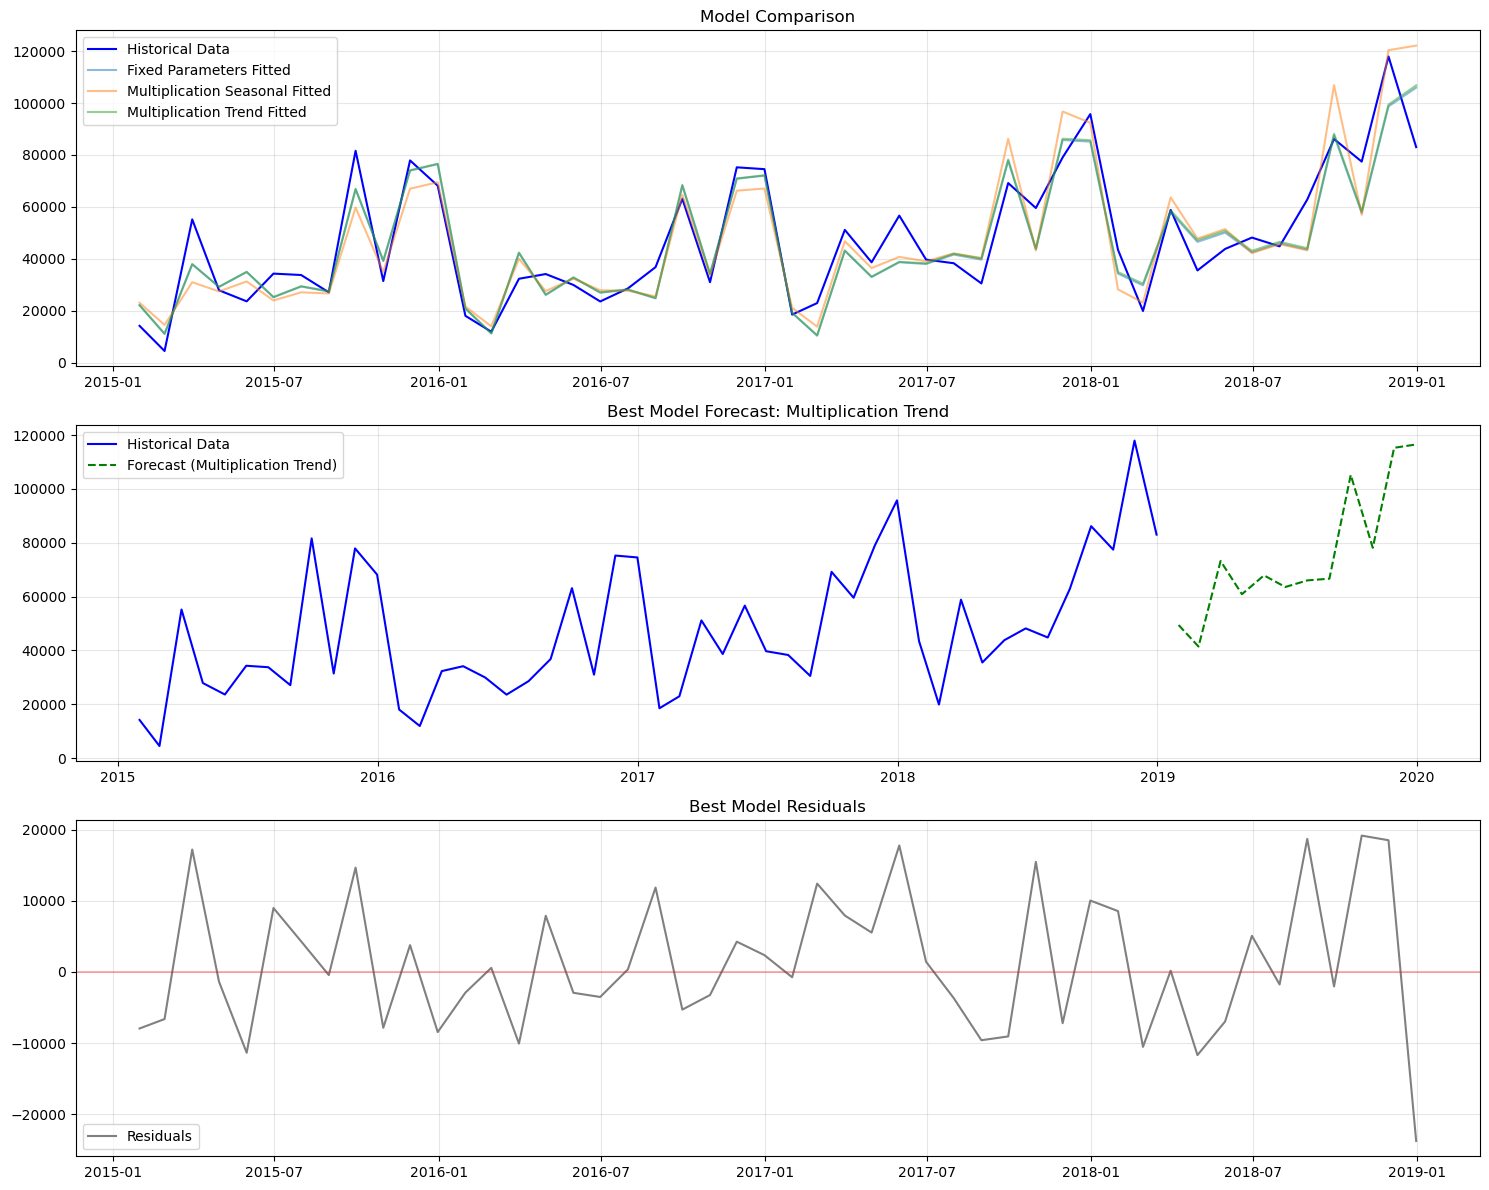

In [166]:
plt.figure(figsize=(15,12))

# First subplot: All models
plt.subplot(3, 1, 1)
plt.plot(monthly_sales.index, monthly_sales, label='Historical Data', color='blue')
for result in results:
    plt.plot(result['model'].fittedvalues.index,
             result['model'].fittedvalues,
             label=f"{result['name']} Fitted",
             alpha=0.5)
plt.title('Model Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Second subplot: Best model forecast
plt.subplot(3, 1, 2)
plt.plot(monthly_sales.index, monthly_sales, label='Historical Data', color='blue')
plt.plot(hw_forecast.index, hw_forecast,
        label=f'Forecast ({best_model["name"]})',
        color='green', linestyle='--')
plt.title(f'Best Model Forecast: {best_model['name']}')
plt.legend()
plt.grid(True, alpha=0.3)

# Third subplot: Residuals of best model
plt.subplot(3, 1,3)
residuals = monthly_sales - hw_model.fittedvalues
plt.plot(monthly_sales.index, residuals, label='Residuals', color='gray')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title('Best Model Residuals')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


    

In [170]:
print("\nModel Comparison:")
for result in results:
    print(f"\n{result['name']}:")
    print(f"RMSE: ${result['rmse']: .2f}")
    print(f"MAE: ${result['mae']: .2f}")

print(f"\nBest Model: {best_model['name']}")
print(f"Best RMSE: ${best_model['rmse']: .2f}")


Model Comparison:

Fixed Parameters:
RMSE: $ 9783.60
MAE: $ 7831.27

Multiplication Seasonal:
RMSE: $ 11758.67
MAE: $ 8762.04

Multiplication Trend:
RMSE: $ 9762.29
MAE: $ 7841.90

Best Model: Multiplication Trend
Best RMSE: $ 9762.29


In [172]:
print("\nBest Model Parameters:")
print(f"- Smoothing level (α): {hw_model.params['smoothing_level']:.3f}")
print(f"- Trend smoothing (β): {hw_model.params['smoothing_trend']:.3f}")
print(f"- Seasonal smoothing (γ): {hw_model.params['smoothing_seasonal']:.3f}")
print(f"- Damping parameter (φ): {hw_model.params['damping_trend']:.3f}")


Best Model Parameters:
- Smoothing level (α): 0.200
- Trend smoothing (β): 0.100
- Seasonal smoothing (γ): 0.100
- Damping parameter (φ): 0.980


In [176]:
hw_forecast

2019-01-31     49435.711479
2019-02-28     41459.506838
2019-03-31     73220.555712
2019-04-30     60904.078997
2019-05-31     67886.536597
2019-06-30     63574.157506
2019-07-31     66020.931715
2019-08-31     66663.177848
2019-09-30    105201.488326
2019-10-31     78140.769889
2019-11-30    115255.953319
2019-12-31    116513.155267
Freq: ME, dtype: float64

In [180]:
final_results = pd.DataFrame({
    'Actual': monthly_sales,
    'Fitted': hw_model.fittedvalues,
    'Residuals': residuals
})

In [182]:
final_results

,Actual,Fitted,Residuals
Order Date,,,
2015-01-31,14205.7070,22155.386037,-7949.679037
2015-02-28,4519.8920,11146.811114,-6626.919114
2015-03-31,55205.7970,37975.018760,17230.778240
2015-04-30,27906.8550,29267.192066,-1360.337066
2015-05-31,23644.3030,35011.240872,-11366.937872
2015-06-30,34322.9356,25323.862069,8999.073531
2015-07-31,33781.5430,29471.746667,4309.796333
2015-08-31,27117.5365,27556.862748,-439.326248
2015-09-30,81623.5268,66942.870651,14680.656149
